# Alan Data

Investigation of MCMC runs done with sky data. Either with an "isolated" model (i.e. sky-data is pre-calibrated with "best" calibration) or "joint" model (i.e. calibration is fit along with the sky model). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from edges_cal import modelling as mdl
from pathlib import Path

import mcmc_utils as mutl
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate.fitting import SemiLinearFit
from getdist import plots

import alan_data_utils as utils
import alan_data as adata
import glob
import run_alan_data_mcmc as mcmc
from scipy import optimize
import notebook_utils as nutl
import pickle
from multiprocessing import Pool
from astropy import units as u
from edges_cal.modelling import LinLog
from yabf import run_map
from alan_data_utils import make_absorption
import run_alan_cal_mcmc as cal
plt.ion()

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
nutl.setup_mpl()

In [9]:
runs = mutl.get_completed_mcsamples(mcmc.mcdef.folder)

In [10]:
isolated = mutl.get_completed_mcsamples('alan_field_isolated')

In [11]:
def get_eor_curves(mc):
    
    kw = mcmc.mcdef.get_kwargs(Path(mc.root).parent.name)
    
    # We have to get nparams this way because we might have constructed with a dodgy .paramnames file.
    lk = mcmc.mcdef.get_likelihood(**kw)
    pidx = [i for i, p in enumerate(lk.partial_linear_model.child_active_params) if p.name in ("A", "nu0", 'w', 'tau')]
    
    nparams = len(lk.partial_linear_model.child_active_params)

    equal_weight_samples = np.genfromtxt(mc.root + "_equal_weights.txt")[:, 2 : (2 + nparams)]
    
    eor = []
    for sample in equal_weight_samples:
        eor.append(lk.eor_components[0](params=sample[pidx])['eor_spectrum'])
        
    return np.array(eor)
    

In [12]:
eormodel = make_absorption(adata.sky_freq)

In [13]:
calobs32 = utils.get_calobs(smooth=32)
labcal32 = utils.get_labcal(calobs32)

In [14]:
iso_eor_curves = {}
for name, mc in isolated.items():
    equal_weight_samples = np.genfromtxt(mc.root + "_equal_weights.txt")[:, 2 : 6]
    
    these = []
    for sample in equal_weight_samples:
        these.append(eormodel(params=sample)['eor_spectrum'])
        
    iso_eor_curves[name] = np.array(these)
        

In [15]:
eor_curves = {}
for name, mc in runs.items():
    eor_curves[name] = get_eor_curves(mc)

In [16]:
fiducial_fits = {}
for name, run in runs.items():
    kw = mcmc.mcdef.get_kwargs(name)
    
    fg = kw['nterms_fg']
    
    if fg in fiducial_fits:
        continue
        
    linlog = mdl.LinLog(n_terms=fg)
    
    # NOTE that this fit has constant variance with frequency!
    slf = SemiLinearFit(
        fg=linlog.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=adata.sky_temp, 
        sigma=0.03
    )
    fiducial_fits[fg] = (slf, slf(dual_annealing_kw={'maxiter':200}))

In [17]:
fiducial_fits_wvar = {}
for name, run in runs.items():
    kw = mcmc.mcdef.get_kwargs(name)
    
    fg = kw['nterms_fg']
    
    if fg in fiducial_fits_wvar:
        continue
        
    linlog = mdl.LinLog(n_terms=fg)
    
    lknew = utils.get_isolated_likelihood(
        labcal32, 
        calobs32,
        fsky=adata.sky_data['freq'],
        fg=linlog, 
        eor=utils.make_absorption(adata.sky_data['freq']),
        ml_solution='outputs/alan_cal/c06_w05_cf06_wf05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsim-False/bayescal.map',
        mcdef=cal.mcdef
    )
    
    res = run_map(lknew.partial_linear_model, dual_annealing_kw={'maxiter': 200})
    fiducial_fits_wvar[fg] = (lknew, res)

In [18]:
fiducial_fits_recal = {}
for name, run in runs.items():
    kw = mcmc.mcdef.get_kwargs(name)
    lk = mcmc.mcdef.get_likelihood(**kw)
    
    fg = kw['nterms_fg']
    
    if fg in fiducial_fits_recal:
        continue
        
    linlog = mdl.LinLog(n_terms=fg)
    recal_tsky = utils.recalibrate(labcal32, t_sky=adata.sky_data["t_ant"], f_sky=adata.sky_freq) 
    
    best = run.samples[np.argmax(-run.loglikes)][:len(lk.partial_linear_model.child_active_params)]
    # tns = lk.partial_linear_model.get_ctx(params=best)['tns_field']
    tns = calobs32.C1(adata.sky_freq*u.MHz) * 1000
    variance = lk.partial_linear_model.data['data_variance']['ant'] * tns**2
    slf = SemiLinearFit(
        fg=linlog.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=recal_tsky, 
        sigma=np.sqrt(variance)
    )
    fiducial_fits_recal[fg] = (slf, slf(dual_annealing_kw={'maxiter':200}))



In [19]:
plt.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

In [21]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#dede00', 
                  '#a65628', '#984ea3',
                  '#e41a1c',  '#999999',]

def plot_inferred_absorption(use='mean', plot_regions=True, ignore=()):
    runss = {k: v for k, v in runs.items() if k not in ignore}
    
    fig, ax = plt.subplots(len(runss)//4 + (len(runss) % 4 > 0), 4, sharex=True, sharey=True, figsize=(1.2*nutl.double_width, 1.2*0.65*nutl.double_width), gridspec_kw={"wspace": 0.05, 'hspace': 0.05})
    
    
    for irun, name in enumerate(sorted(runss.keys(), key=lambda key: mcmc.mcdef.get_kwargs(key)['nterms_fg'])):
        mc = runs[name]
        kw = mcmc.mcdef.get_kwargs(Path(mc.root).parent.name)
        lk = mcmc.mcdef.get_likelihood(**kw)
        nparams = len(lk.partial_linear_model.child_active_params)
        ev_joint = mutl.get_evidence(mc.root)
        
        pidx = [i for i, p in enumerate(lk.partial_linear_model.child_active_params) if p.name in ("A", "nu0", 'w', 'tau')]
        
        if use in ('mean', 'ml'):
            
            if use == 'mean':
                best = mc.getMeans()[pidx]
            elif use == 'ml':
                best = mc.samples[np.argmax(-mc.loglikes)][pidx]
   
            eor = lk.eor_components[0](params=best)['eor_spectrum']
        elif use == 'median':
            eor = np.median(eor_curves[name], axis=0)
            
        iso = iso_eor_curves[f"c06_w05_smooth32_fg{kw['nterms_fg']}_taufxFalse_calmapTrue"]
        ev_iso = mutl.get_evidence(f"outputs/alan_field_isolated/c06_w05_smooth32_fg{kw['nterms_fg']}_taufxFalse_calmapTrue/bayescal")
        
        if plot_regions:
            p = np.percentile(eor_curves[name], (2.5, 16, 84, 97.5), axis=0)
         
            ax.flatten()[irun].fill_between(adata.sky_freq, p[0], p[-1], alpha=0.4, color=CB_color_cycle[irun], lw=0)
            ax.flatten()[irun].fill_between(adata.sky_freq, p[1], p[-2], alpha=0.8, color=CB_color_cycle[irun], lw=0)
            
            p = np.percentile(iso, (2.5, 16, 84, 97.5), axis=0)
            
            ax.flatten()[irun].fill_between(adata.sky_freq, p[0], p[-1], facecolor=f"none", lw=0.5, hatch='///////',edgecolor="darkgrey", )
            ax.flatten()[irun].fill_between(adata.sky_freq, p[1], p[-2], facecolor=f"none", lw=0, hatch='\\\\\\\\\\\\\\', edgecolor="darkgrey")
            
        ax.flatten()[irun].plot(adata.sky_freq, eor, color=CB_color_cycle[irun], label='Joint')
        ax.flatten()[irun].text(79, -0.08, str(kw['nterms_fg']), horizontalalignment='center', verticalalignment='center')
        ax.flatten()[irun].text(55, -2.0, r"ln$\mathcal{Z}$:")
        ax.flatten()[irun].text(68, -2.0, f"{ev_joint:.0f}", color=f"C{irun}")
        ax.flatten()[irun].text(88, -2.0, f"{ev_iso:.0f}", color="darkgrey")
        
        
        
        
        # slf, res = fiducial_fits[kw['nterms_fg']]
        # ax.flatten()[irun].plot(adata.sky_freq, slf.get_eor(res.x), color='k', ls='--', label='Isolated ML')

        # The 'non-weighted' fits all match the weighted ones, soo no point plotting them here.
        # slf, res = fiducial_fits[kw['nterms_fg']]
        # ax.flatten()[irun].plot(adata.sky_freq, slf.get_eor(res.x), color='k', ls=':', label='Isolated ML unw')

        ax.flatten()[irun].plot(adata.sky_freq, np.median(iso, axis=0), color=f'darkgrey', ls='--', label='Isolated')
        
    for axx in ax.flatten()[(irun+1):]:
        axx.axis('off')
        
    ax[0,0].legend(bbox_to_anchor=(3.2, -0.5), loc='upper left')
    # for axx in ax[-1]:
    #     axx.set_xlabel("Frequency [MHz]")

    fig.supylabel(r"$\hat{T}_{21}$ [K]")
    fig.supxlabel("Frequency [MHz]")
    plt.tight_layout()
    #plt.legend()

/tmp/ipykernel_11129/3477049054.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


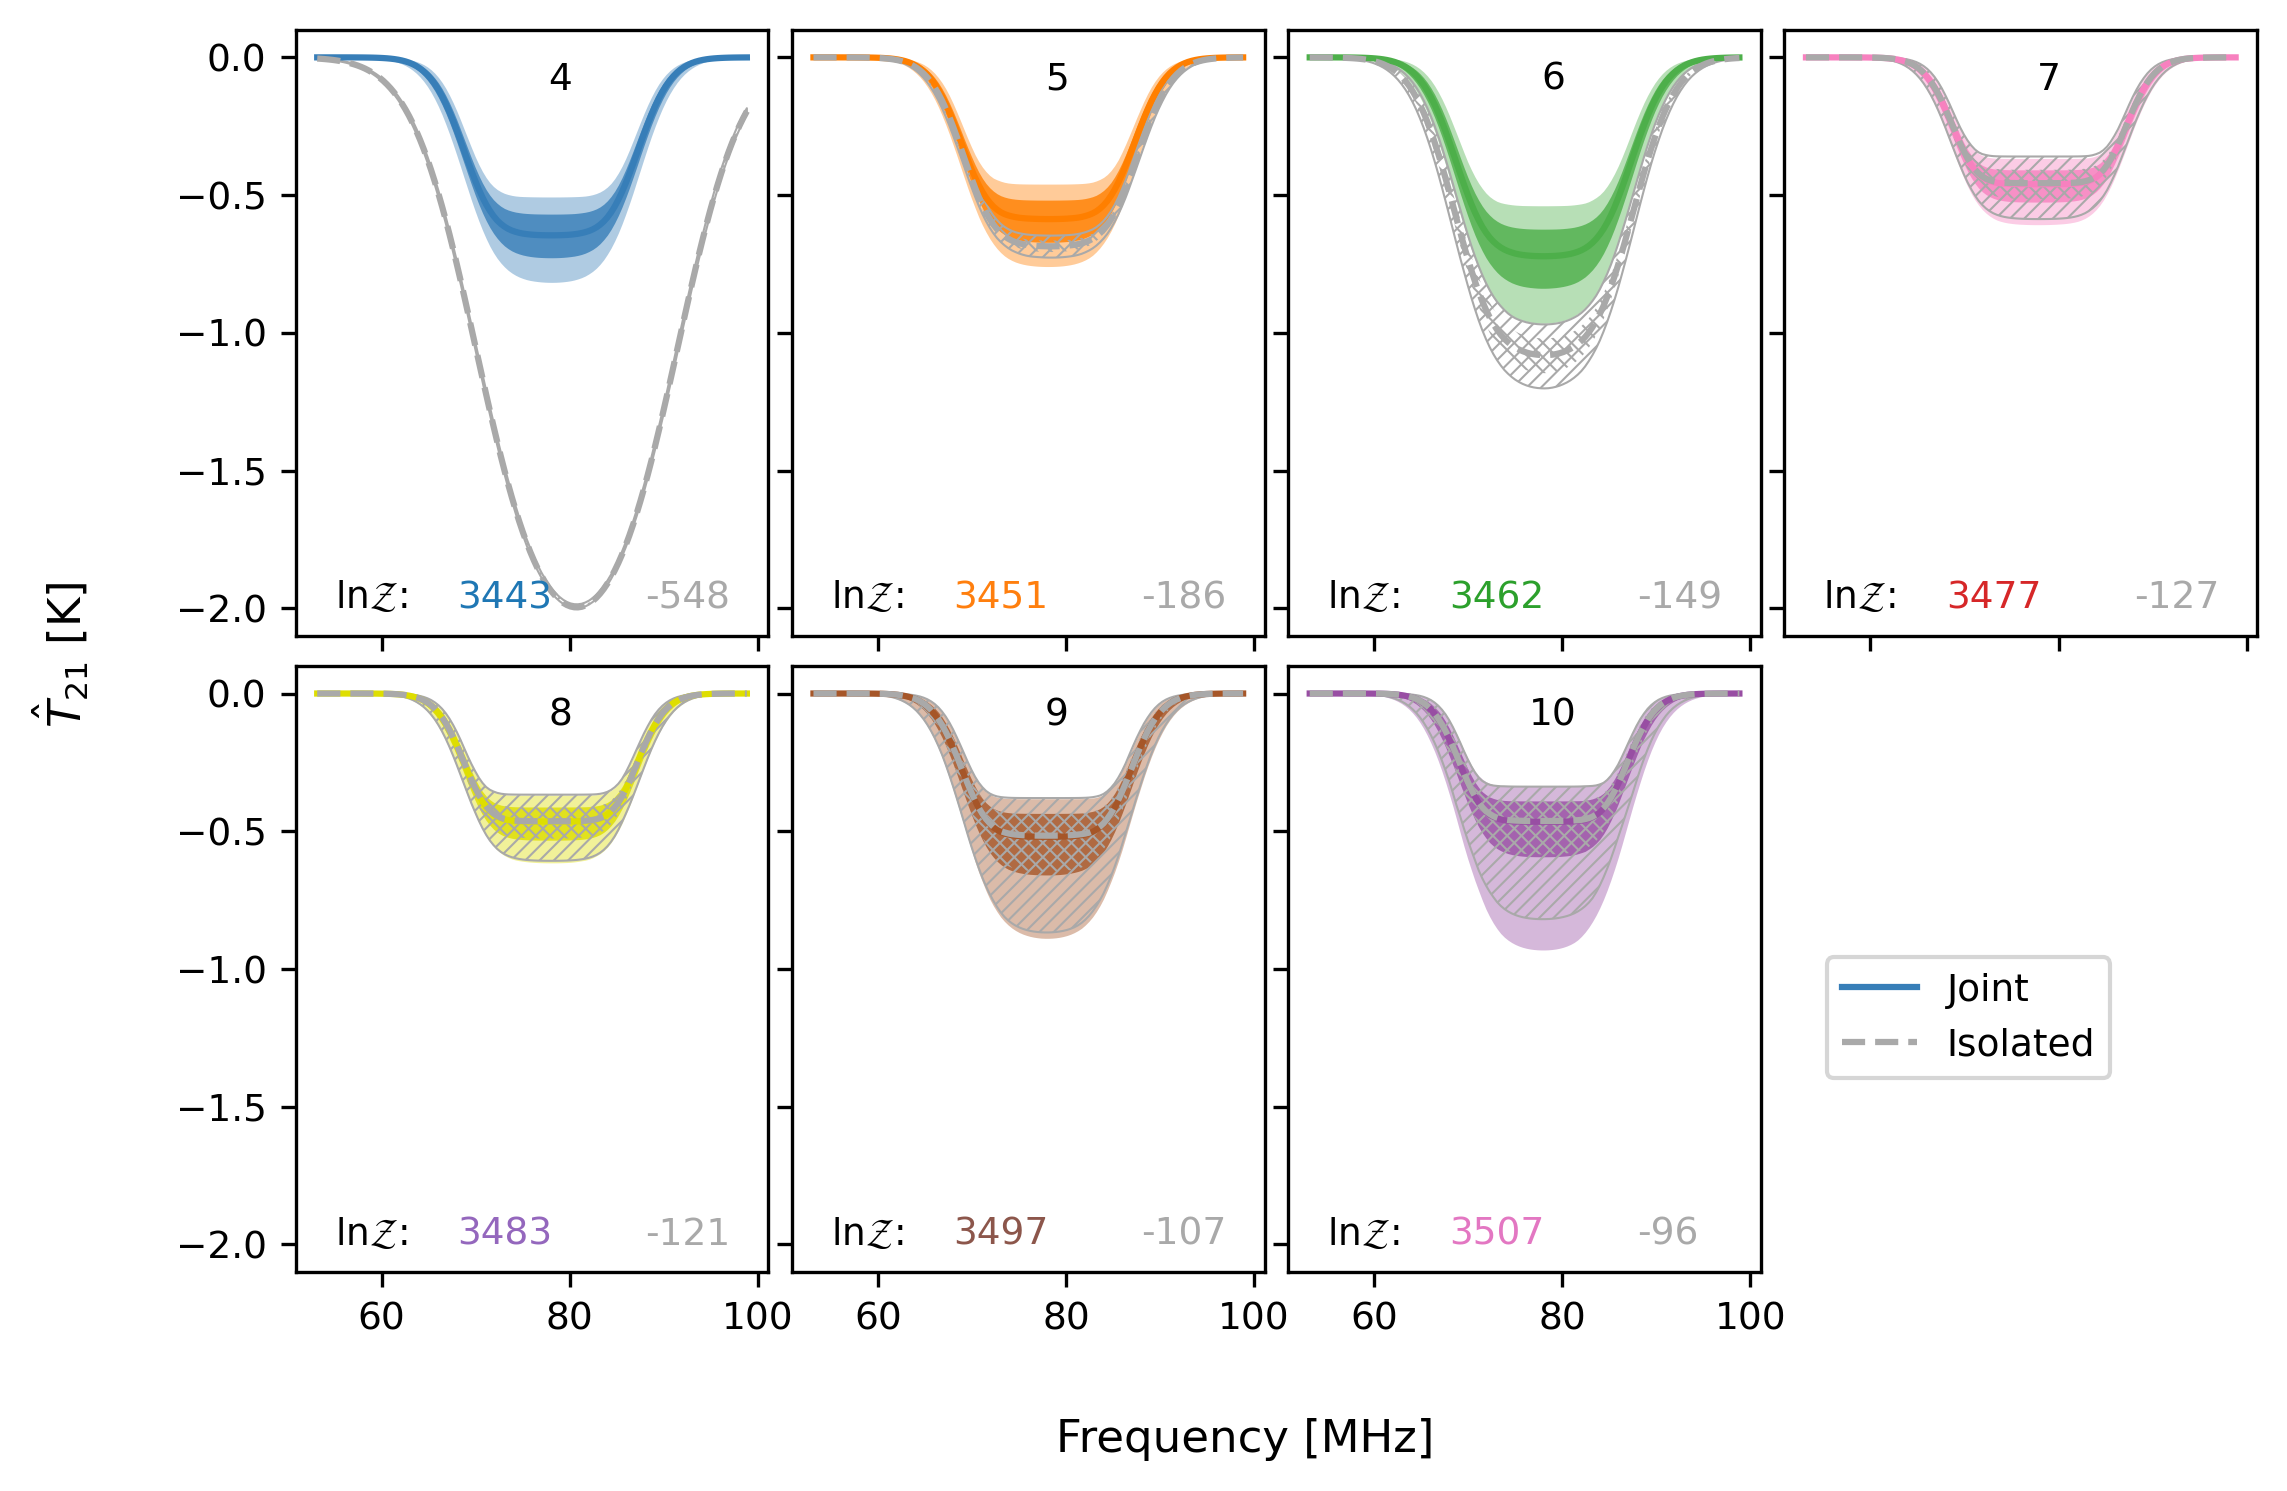

In [23]:
plot_inferred_absorption('median')
plt.savefig("plots/final_absorption_features.pdf")

## Plot calibration TNS for differnt NFG

In [24]:
calobs32 = utils.get_calobs(smooth=32)

In [25]:
for a in runs.values():
    n = 0
    for name in a.paramNames.names:
        if name.name.startswith("t_lns"):
            name.label = r"T^{\rm NS}_{%s}"%n
            n += 1

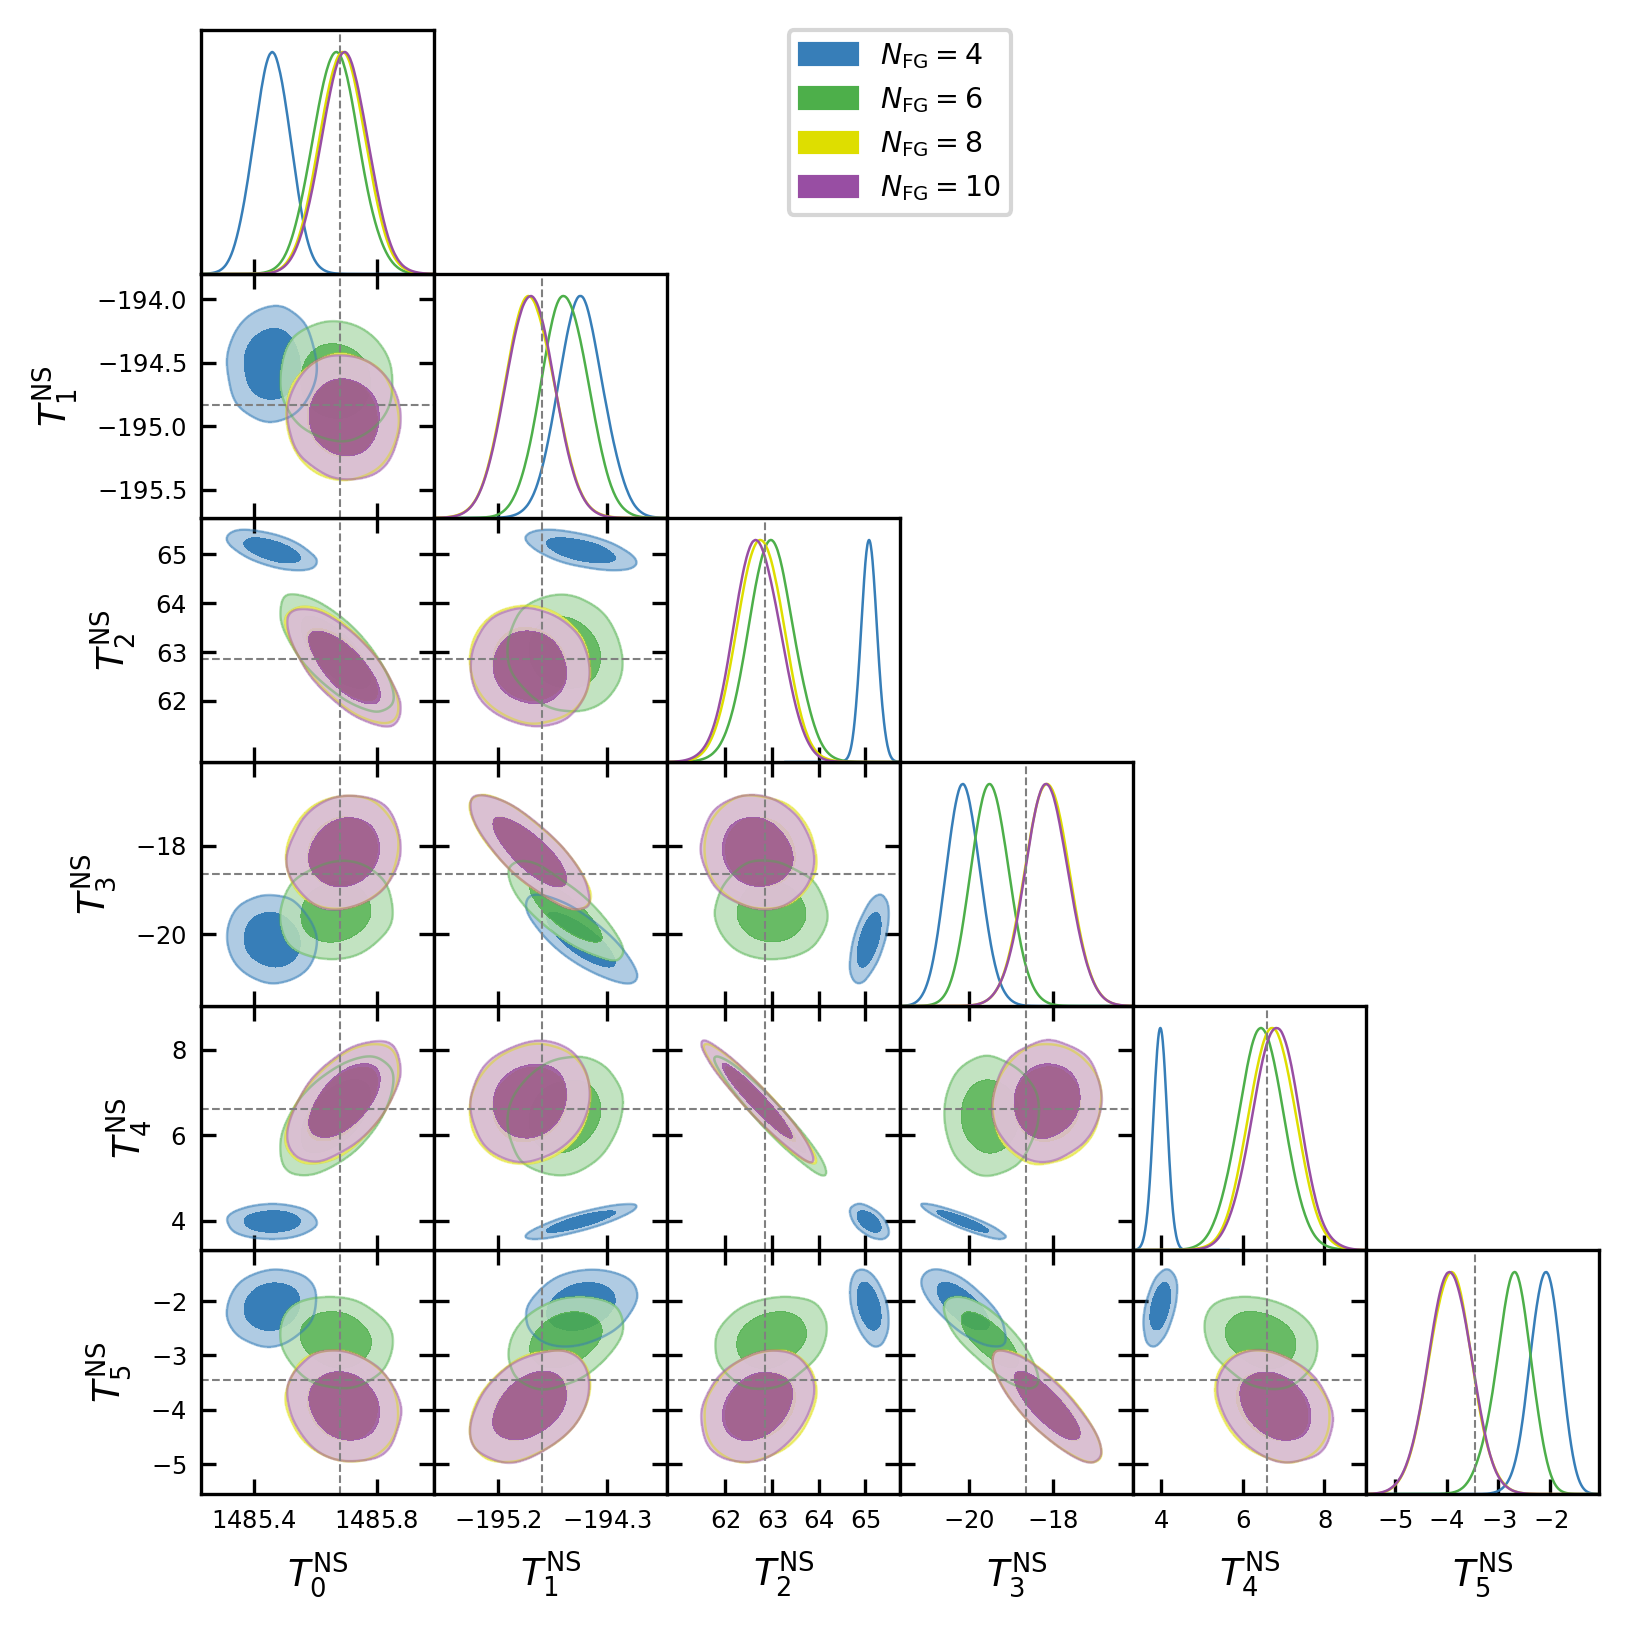

In [26]:
g = plots.get_subplot_plotter(width_inch=5.5)
g.triangle_plot(
    [
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg4_simulTrue_taufxFalse_ns00_nd00_sd1234'],
 #       runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg5_simulTrue_taufxFalse_ns00_nd00_sd1234'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg6_simulTrue_taufxFalse_ns00_nd00_sd1234'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg8_simulTrue_taufxFalse_ns00_nd00_sd1234'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg10_simulTrue_taufxFalse_ns00_nd00_sd1234'],
  
    ], 
    filled=True,
    contour_colors=[CB_color_cycle[0], CB_color_cycle[2], CB_color_cycle[4], CB_color_cycle[6]],
    legend_labels=[
        r'$N_{\rm FG}=4$',
#        r'$N_{\rm FG}=5$',
        r'$N_{\rm FG}=6$',
        r'$N_{\rm FG}=8$',
        r'$N_{\rm FG}=10$',
     
    ],
    params=('t_lns_0', 't_lns_1', 't_lns_2', 't_lns_3', 't_lns_4', 't_lns_5'),
    markers={f't_lns_{i}': 1000*c for i, c in enumerate(calobs32.C1_poly.coefficients[::-1])}
)
plt.savefig("plots/posterior_tns.pdf")

## Plot of T0 and T1 posteriors

In [10]:
blobs = {name: mcmc.get_linear_distribution(mcmc.mcdef, smpl, nthreads=8) for name, smpl in runs.items()}

In [11]:
blobs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg10_simulTrue_taufxFalse_ns00_nd00_sd1234']['a'].shape

(25358, 118)

In [12]:
a, b = labcal32.get_linear_coefficients(freq=adata.sky_freq * u.MHz)
b += calobs32.t_load * a
a *= calobs32.t_load_ns

In [17]:
from matplotlib.colors import to_rgba

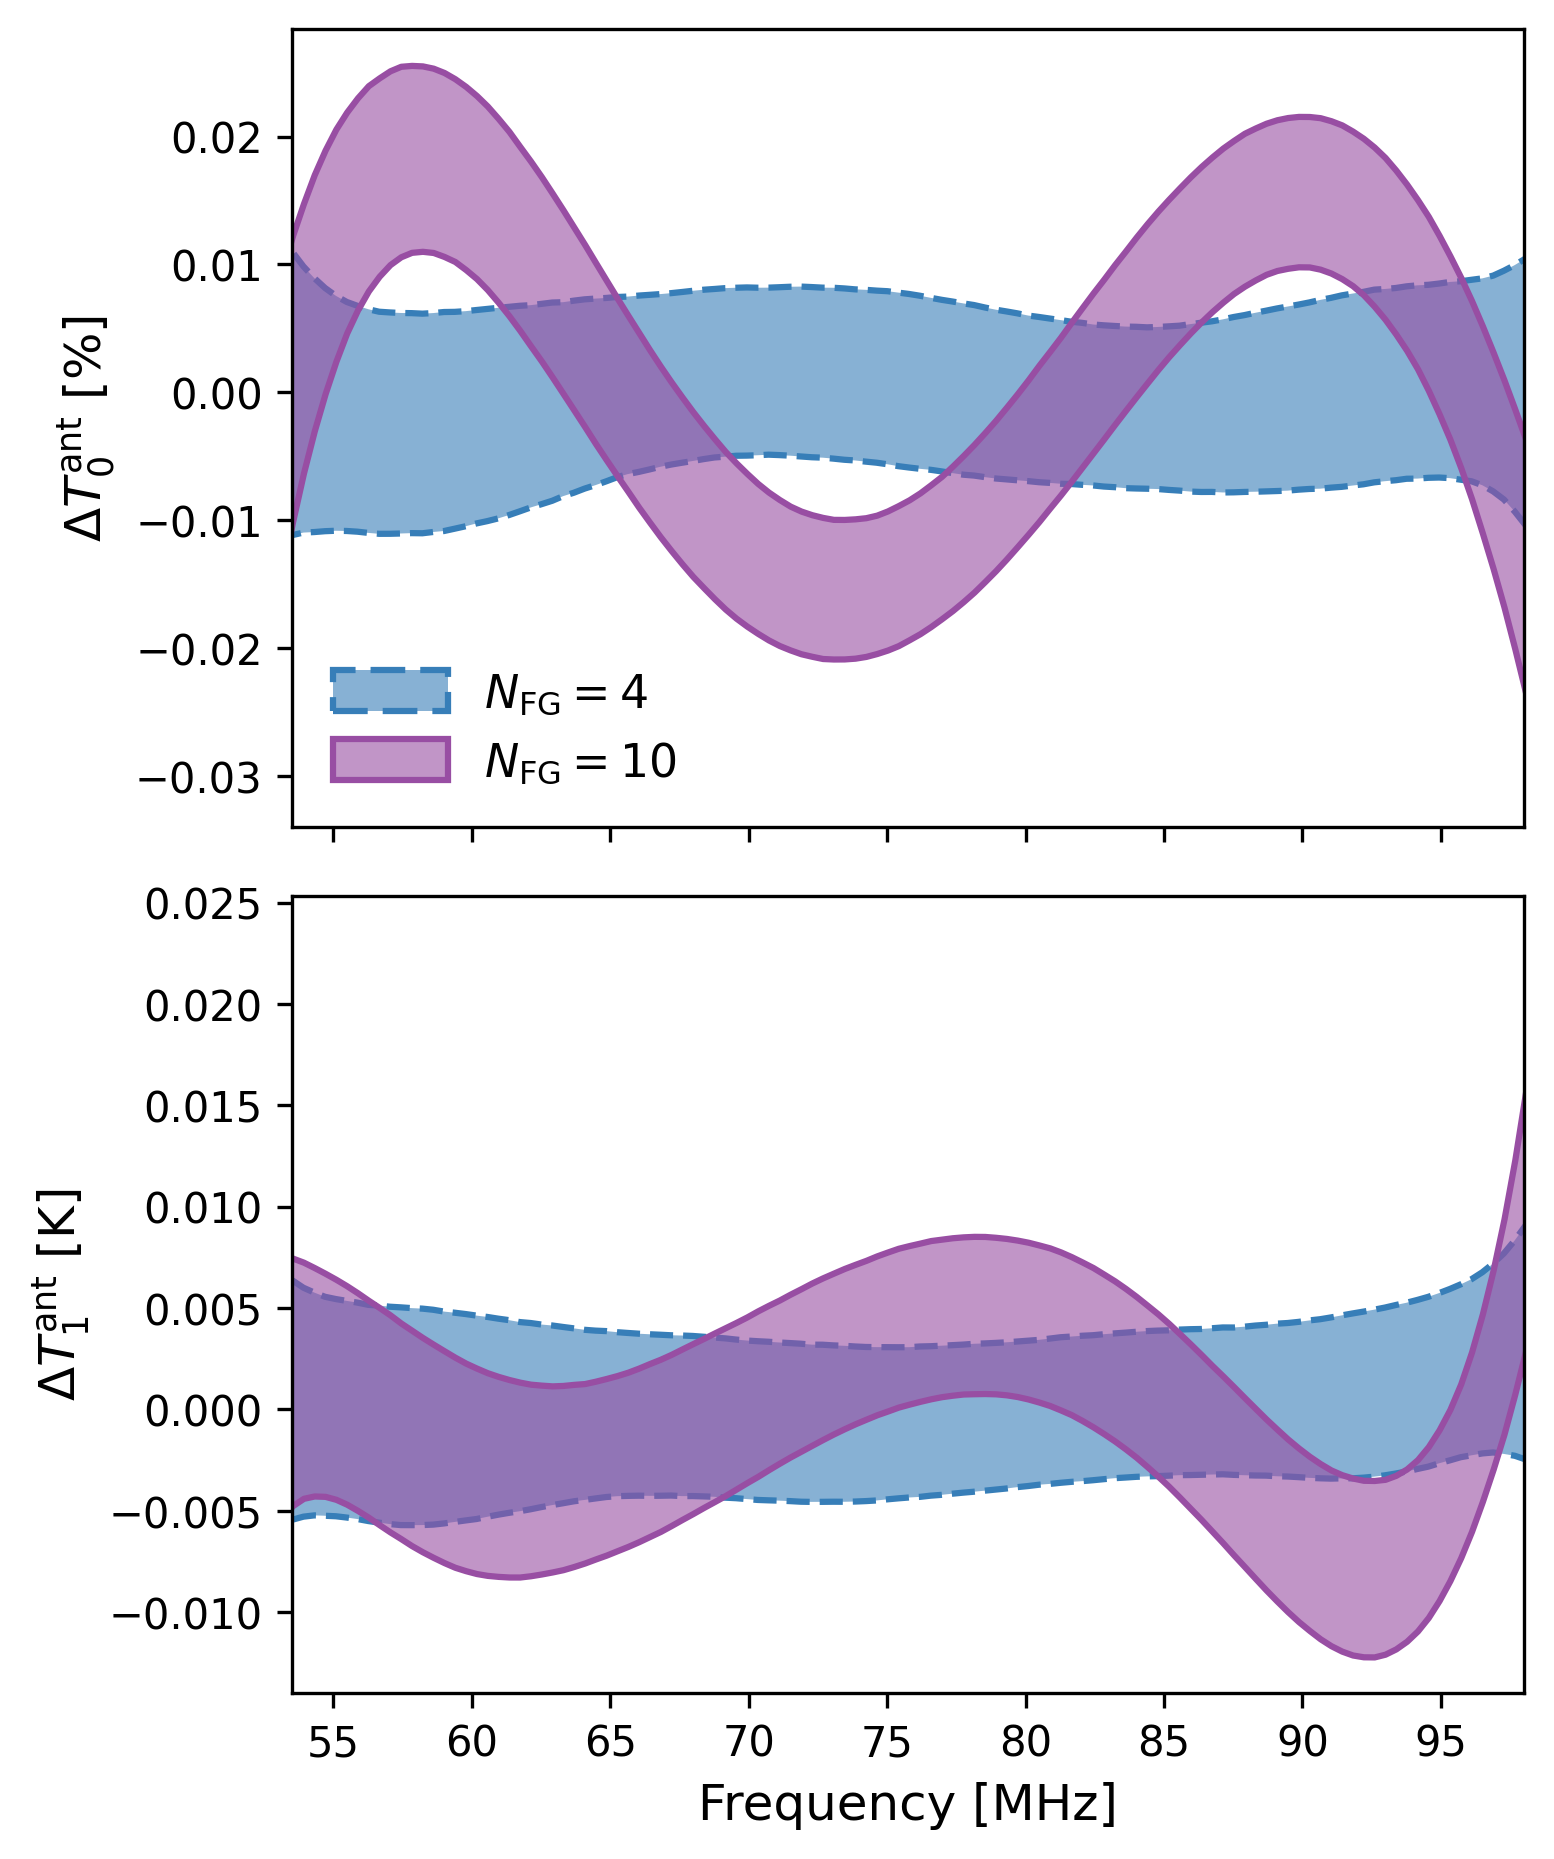

In [21]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(1.5*nutl.single_width, 1.2*1.5*nutl.single_width), gridspec_kw={'hspace': 0.05}, constrained_layout=True)

n = 0
for name, blob in blobs.items():
    if not ('fg4' in name or 'fg10' in name):
        continue
        
    clr = nutl.CB_color_cycle[0] if n==0 else nutl.CB_color_cycle[6]
    
    pa = np.percentile(blob['a'], (2.5, 16, 50, 84, 97.5), axis=0)
    pa = 100*(pa/a - 1)
    
    pb = np.percentile(blob['b'], (2.5, 16, 50, 84, 97.5), axis=0)
    pb -= b
    
    #ax[0].fill_between(adata.sky_freq, pa[0], pa[-1], alpha=0.2, color=clr, lw=0)
    ax[0].fill_between(adata.sky_freq, pa[1], pa[-2], facecolor=to_rgba(clr, 0.6), edgecolor=clr, lw=1.5, ls=['--', '-'][n], label=r'$N_{\rm FG}=%s$'%(4 if n==0 else 10))
    ax[0].set_ylabel(r"$\Delta T^{\rm ant}_0$ [%]")
    
    #ax[1].fill_between(adata.sky_freq, pb[0], pb[-1], alpha=0.2, color=clr,lw=0)
    ax[1].fill_between(adata.sky_freq, pb[1], pb[-2], facecolor=to_rgba(clr, 0.6), edgecolor=clr, lw=1.5, ls=['--', '-'][n])
    ax[1].set_ylabel(r"$\Delta T^{\rm ant}_1$ [K]")
    n += 1
    
ax[0].legend(loc='lower left', ncol=1, frameon=False, handlelength=2.5, handleheight=1)
plt.xlim(53.5,98)
ax[1].set_xlabel("Frequency [MHz]")
plt.savefig("plots/posteriors_of_linear_coeffs.pdf")

## Plot of 21cm Posteriors

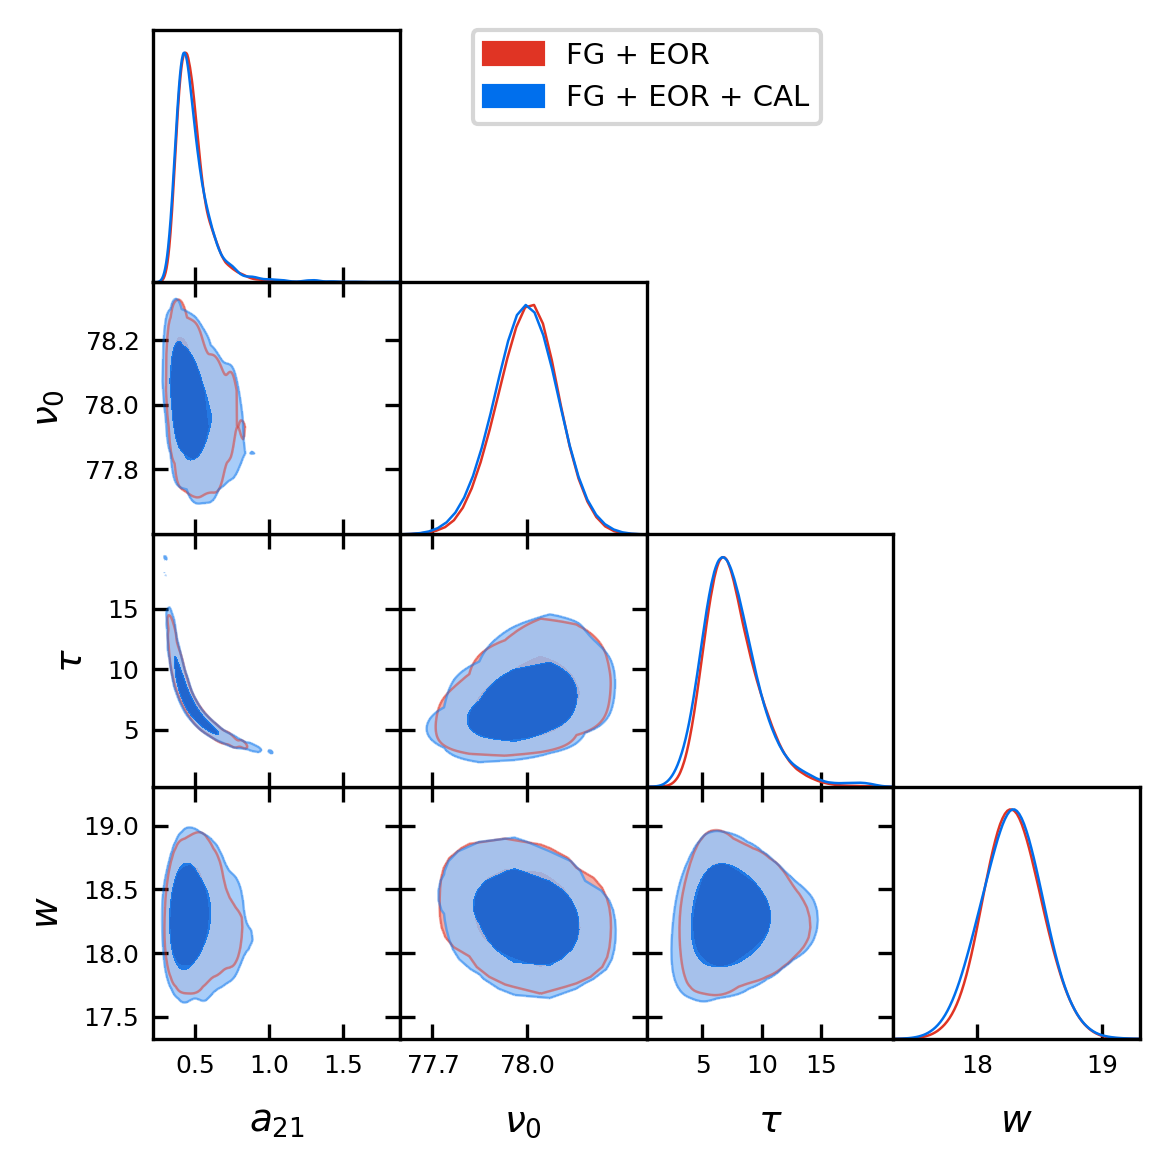

In [66]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot(
    [
        isolated['c06_w05_smooth32_fg10_taufxFalse'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg10_simulTrue_taufxFalse_ns00_nd00_sd1234'],
    ], 
    filled=True,
    legend_labels=[
        'FG + EOR',
        'FG + EOR + CAL'
    ],
    params=('A', 'nu0', 'tau', 'w',),
)
plt.savefig("plots/posterior_t21params.pdf")

## Comparison of SNR

In [24]:
runs.keys()

dict_keys(["c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg10_simulTrue_taufxFalse_ns00_nd00_sd1234", "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg4_simulTrue_taufxFalse_ns00_nd00_sd1234", "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg5_simulTrue_taufxFalse_ns00_nd00_sd1234", "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg6_simulTrue_taufxFalse_ns00_nd00_sd1234", "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg7_simulTrue_taufxFalse_ns00_nd00_sd1234", "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg8_simulTrue_taufxFalse_ns00_nd00_sd1234", "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg9_simulTrue_taufxFalse_ns00_nd00_sd1234"])

In [4]:
kw = mcmc.mcdef.get_kwargs("c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg10_simulTrue_taufxFalse_ns00_nd00_sd1234")
lk = mcmc.mcdef.get_likelihood(**kw)

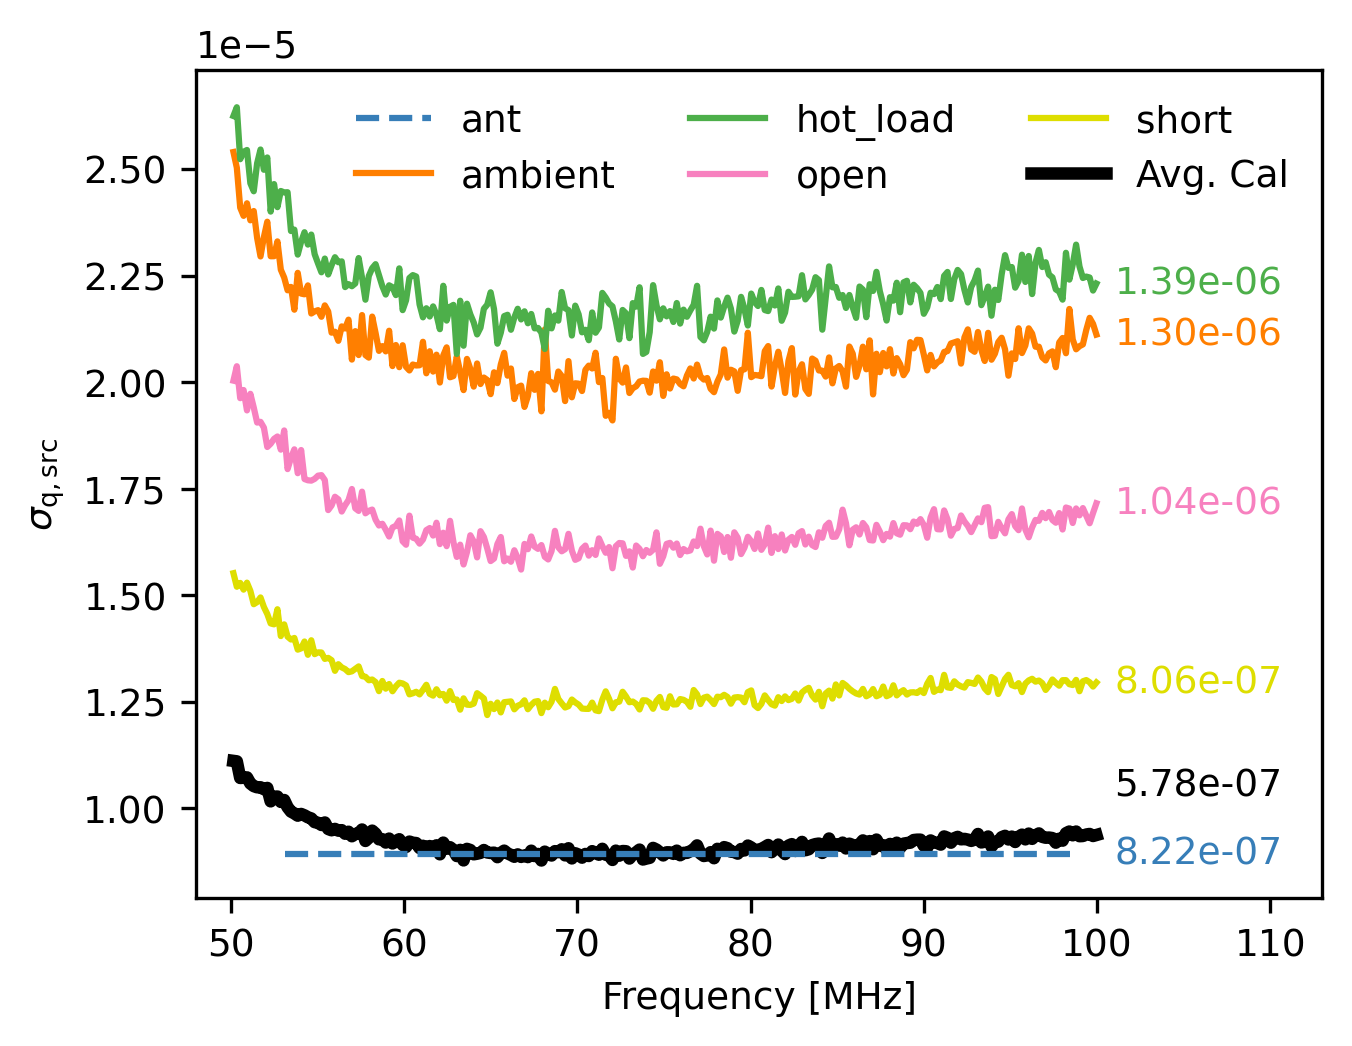

In [8]:
sm = 0
n = 0
s2 = r"$\overline{\sigma^2}$"
vv = 0
fig, ax = plt.subplots(1, 1, figsize=(nutl.single_width*1.3, nutl.single_width), constrained_layout=True)

for i, (k, v) in enumerate(lk.data['data_variance'].items()):
    if k == 'ant':
        plt.plot(lk.nwfg_model.field_freq, np.sqrt(v), label=k, ls='--', color=nutl.CB_color_cycle[i])
    else:
        plt.plot(lk.nwfg_model.freq, np.sqrt(v), label=k, color=nutl.CB_color_cycle[i])
        vv += v
        sm += np.sum(v)
        n += len(v)
        
    plt.text(101, np.sqrt(v[-1]), fr"{np.sqrt(np.sum(v))/len(v):1.2e}", color=nutl.CB_color_cycle[i], verticalalignment='center')

plt.plot(lk.nwfg_model.freq, np.sqrt(vv)/4, label="Avg. Cal", color='k', lw=3, zorder=-1)

plt.text(101, 1.03e-5, f"{np.sqrt(sm)/n:1.2e}")
plt.xlim(48, 113)
plt.xlabel("Frequency [MHz]")
plt.ylabel(r"$\sigma_{\rm q, src}$")

plt.legend(ncol=3, frameon=False)

plt.savefig("plots/comparative_uncertainty.pdf")


## Plot of posterior correlation matrix.

In [84]:
for a in runs.values():
    for beginning,latex in [('t_lns', r"T^{\rm NS}"), ('tfghat', r'T^{\rm FG}'), ('tunchat', r'T^{\rm unc}'), ('tcoshat', r"T^{\rm cos}"), ('tsinhat', r"T^{\rm sin}"), ('tloadhat', r"T^{\rm L}")]:
        n = 0
        for name in a.paramNames.names:
            if name.name.startswith(beginning):
                name.label = latex + "_{%s}"%n
                n += 1

In [68]:
fg4 = runs["c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg4_simulTrue_taufxFalse_ns00_nd00_sd1234"]

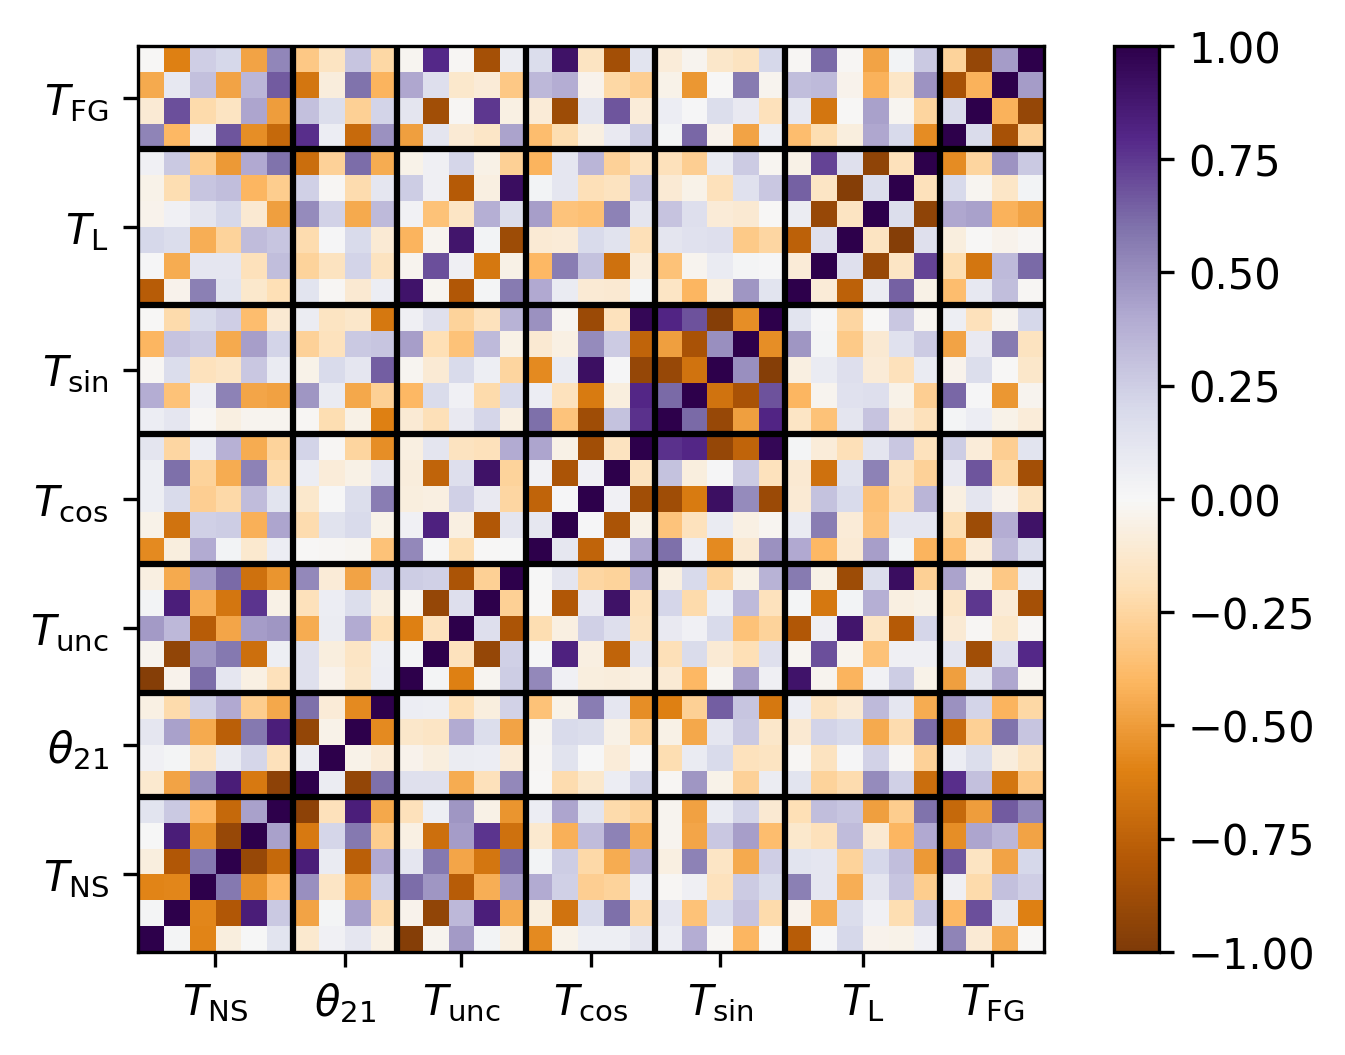

In [109]:
plt.imshow(fg4.getCorrelationMatrix()[:35, :35], cmap='PuOr', clim=(-1,1), origin='lower')

x_label_list = [f"${p.label}$" for p in fg4.getParamNames().names][:35]
x_label_list = [r"$T_{\rm NS}$", r"$\theta_{21}$", r"$T_{\rm unc}$", r"$T_{\rm cos}$", r"$T_{\rm sin}$", r"$T_{\rm L}$", r"$T_{\rm FG}$"]

xticks = np.array([3, 6 + 2, 10+2.5, 17.5, 22.5, 28, 33]) -0.5
plt.xticks(xticks)
plt.gca().set_xticklabels(x_label_list)

plt.yticks(xticks)
plt.gca().set_yticklabels(x_label_list)

plt.axhline(6 - 0.5, color='k')
plt.axhline(10 - 0.5, color='k')
plt.axhline(15 - 0.5, color='k')
plt.axhline(20 - 0.5, color='k')
plt.axhline(25 - 0.5,color='k')
plt.axhline(31 - 0.5, color='k')


plt.axvline(6 - 0.5, color='k')
plt.axvline(10 - 0.5, color='k')
plt.axvline(15 - 0.5, color='k')
plt.axvline(20 - 0.5, color='k')
plt.axvline(25 - 0.5,color='k')
plt.axvline(31 - 0.5, color='k')

plt.colorbar()

## Triangle Plots of all Parameters

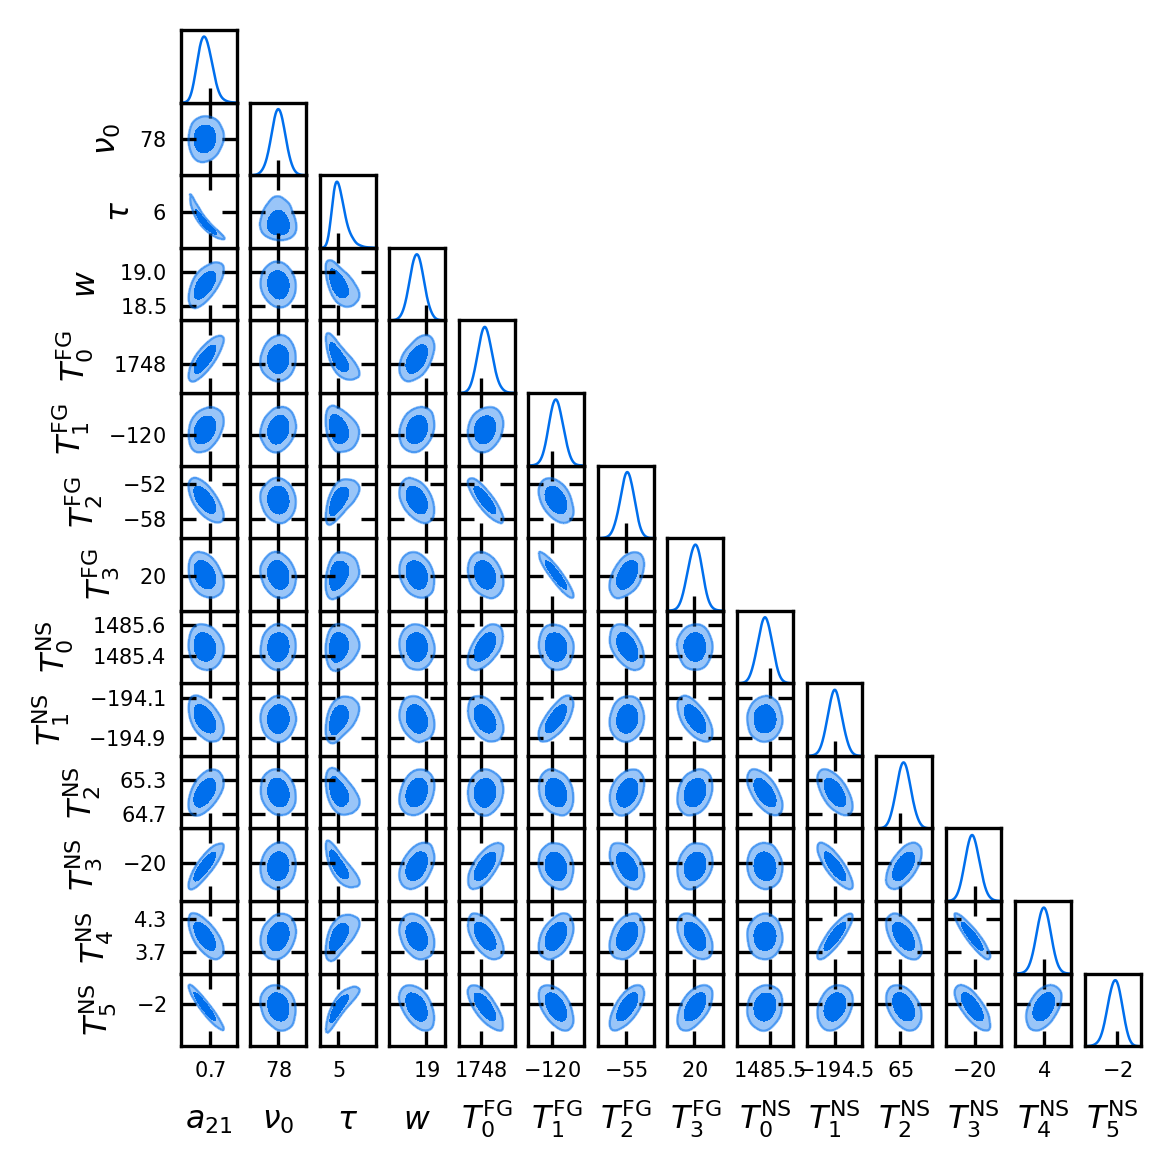

In [77]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot(
    [
        fg4
    ], 
    filled=True,
    params=(
        'A', 'nu0', 'tau', 'w', 'tfghat_0', 'tfghat_1', 'tfghat_2','tfghat_3', 
        't_lns_0', 't_lns_1','t_lns_2','t_lns_3','t_lns_4','t_lns_5',     
    )    
)

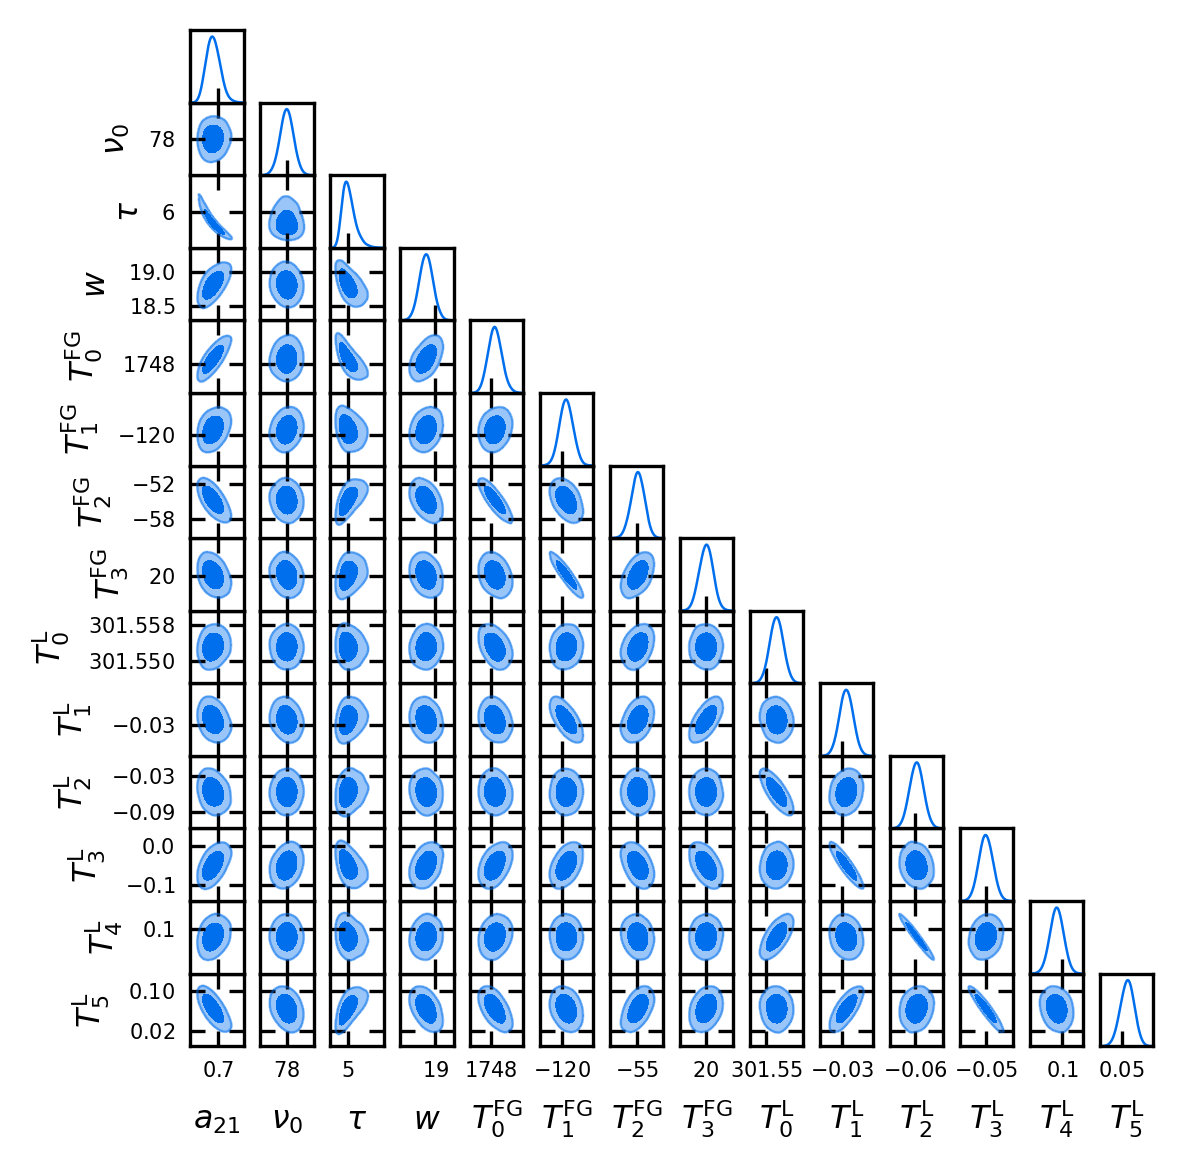

In [85]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot(
    [
        fg4
    ], 
    filled=True,
    params=(
        'A', 'nu0', 'tau', 'w', 'tfghat_0', 'tfghat_1', 'tfghat_2','tfghat_3', 
        'tloadhat_0', 'tloadhat_1','tloadhat_2','tloadhat_3','tloadhat_4', 'tloadhat_5',
    )    
)

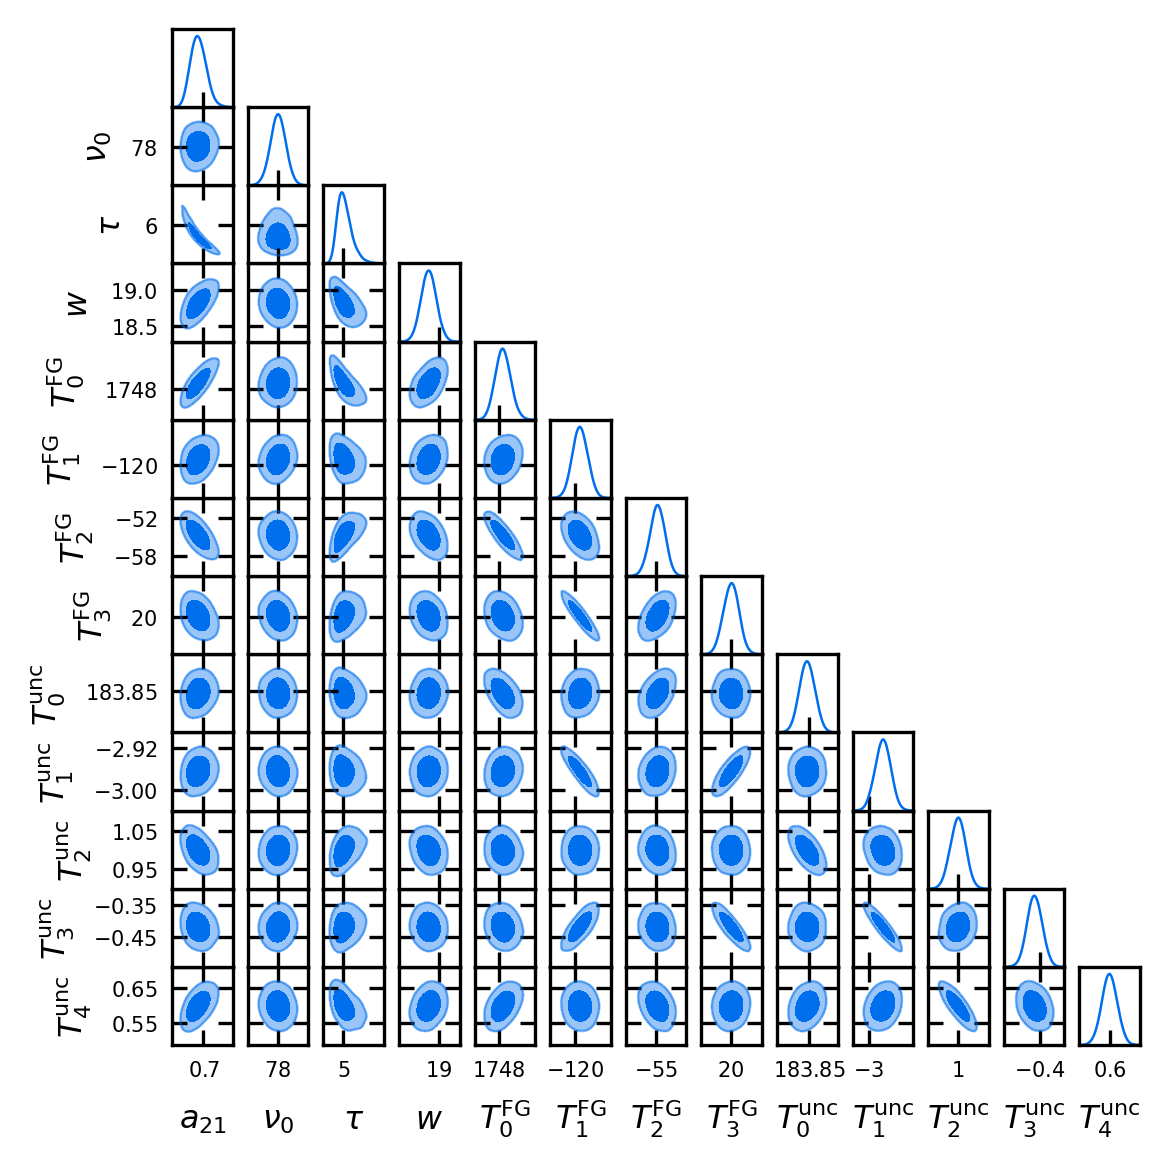

In [81]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot(
    [
        fg4
    ], 
    filled=True,
    params=(
        'A', 'nu0', 'tau', 'w', 'tfghat_0', 'tfghat_1', 'tfghat_2','tfghat_3', 
        'tunchat_0', 'tunchat_1','tunchat_2','tunchat_3','tunchat_4',
    )    
)

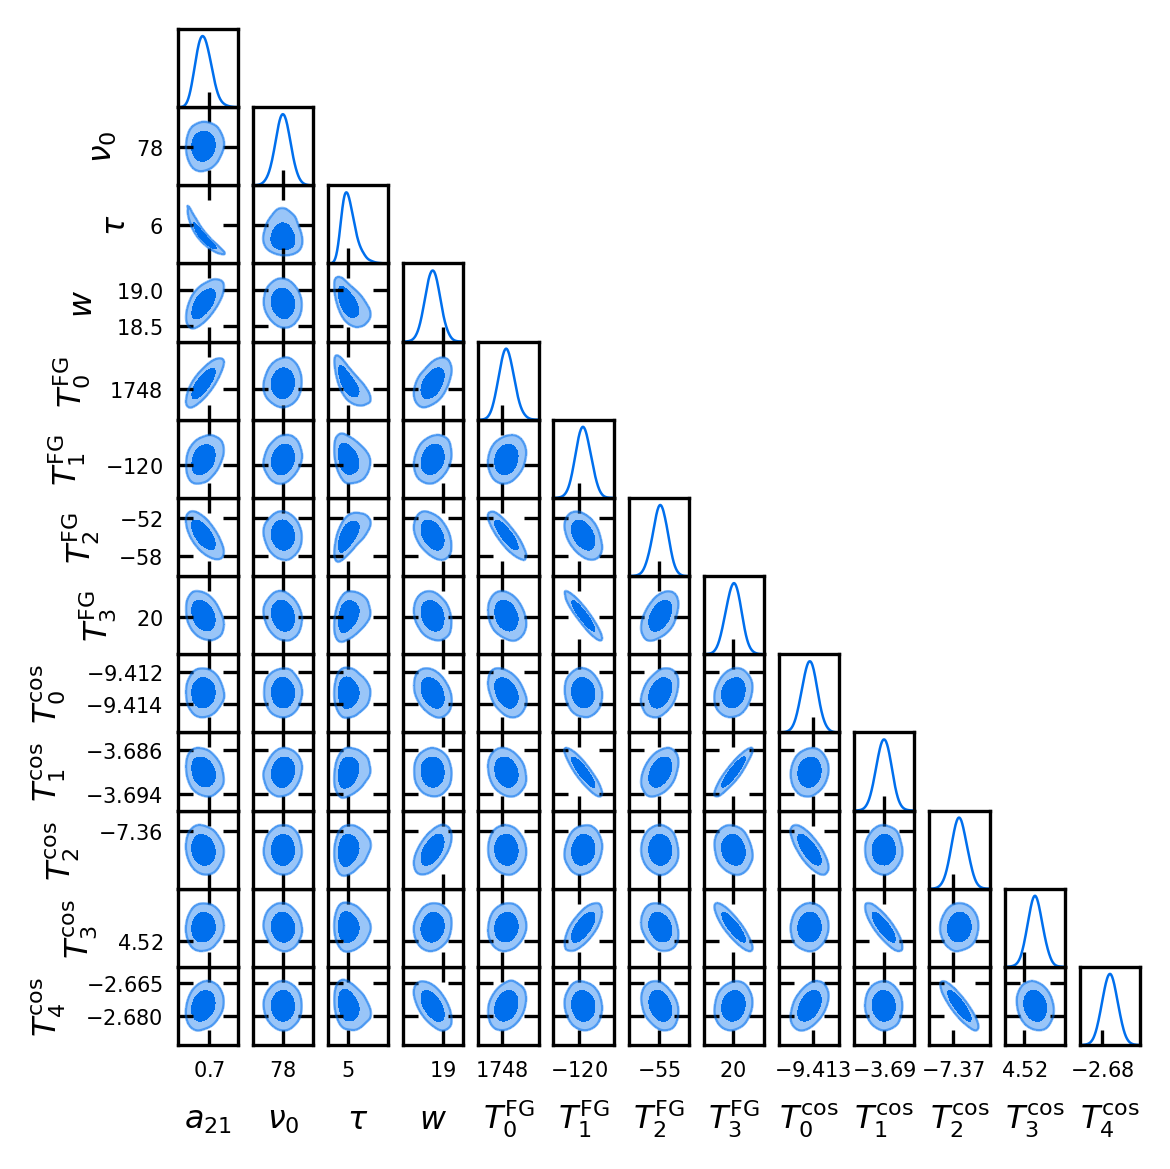

In [82]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot(
    [
        fg4
    ], 
    filled=True,
    params=(
        'A', 'nu0', 'tau', 'w', 'tfghat_0', 'tfghat_1', 'tfghat_2','tfghat_3', 
        'tcoshat_0', 'tcoshat_1','tcoshat_2','tcoshat_3','tcoshat_4',
    )    
)

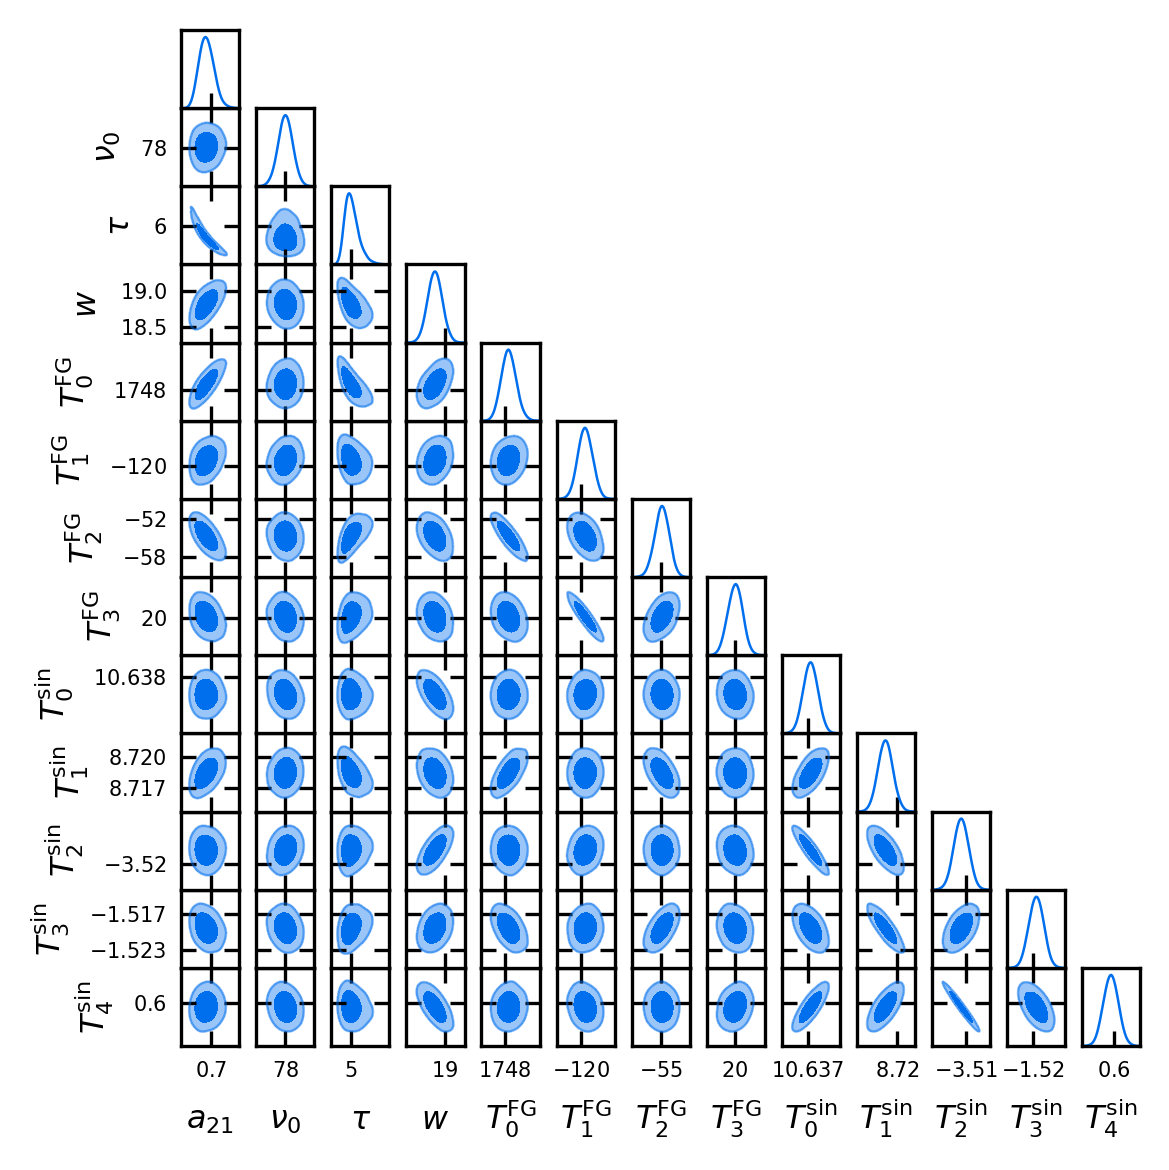

In [83]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot(
    [
        fg4
    ], 
    filled=True,
    params=(
        'A', 'nu0', 'tau', 'w', 'tfghat_0', 'tfghat_1', 'tfghat_2','tfghat_3', 
        'tsinhat_0', 'tsinhat_1','tsinhat_2','tsinhat_3','tsinhat_4',
    )    
)